# Neural Networks and Linear Regression

In [89]:
%matplotlib inline

from itertools import combinations

import pandas as pd
from datetime import datetime
import numpy as np
import os

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.linear_model import LinearRegression

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F


import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [5]:
## Custom plotly plot styling

# Remove the red color in discrete color scale
px.colors.qualitative.Plotly = px.colors.qualitative.Plotly[:1] + px.colors.qualitative.Plotly[2:]

pio.templates["custom"] = go.layout.Template(
    layout=go.Layout(
        paper_bgcolor="rgba(0, 0, 0, 0)",
        font=dict(color="lightgreen"),
        colorscale=dict(sequential="Viridis"),
        colorway=px.colors.qualitative.Plotly)
)

pio.templates.default = "plotly+custom"

# Settings for plot rendering, makes work with HTML output + jupyer lab + static output
pio.renderers.default = "plotly_mimetype+notebook_connected+png"

## Load Data

In [2]:
data_path = os.path.normpath("../data/products_cleaned.csv")
df_az = pd.read_csv(data_path, dtype={"Category": "category"}, parse_dates=["Date Scraped"])

print(df_az.dtypes)
df_az

Asin                       object
Name                       object
Image Url                  object
Is Best Seller               bool
Stars                     float64
Reviews                   float64
Url                        object
Price                     float64
Date Scraped       datetime64[ns]
List Price                float64
Bought In Month           float64
Category                 category
dtype: object


,Asin,Name,Image Url,Is Best Seller,Stars,Reviews,Url,Price,Date Scraped,List Price,Bought In Month,Category
0,B0CSPPHXXV,Apple Watch Ultra 2 (GPS + Cellular 49mm) Rugg...,https://m.media-amazon.com/images/I/814xH1gpid...,False,NaN,0.0,https://www.amazon.com/Apple-Cellular-Rugged-T...,699.97,2024-02-01,779.99,NaN,NaN
1,B0BDJ4MGFQ,AppleWatch Series 8 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/91WpS8h5Jv...,False,4.7,4100.0,https://www.amazon.com/Apple-Cellular-Starligh...,689.00,2024-02-01,799.00,NaN,NaN
2,B0CSV7LK7D,AppleWatch Series 9 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/61DZ+Vezk0...,False,NaN,0.0,https://www.amazon.com/Apple-Cellular-Smartwat...,679.00,2024-02-01,679.00,NaN,NaN
3,B0B8GHHD2F,AppleWatch Series 7 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/51aQmgx9Ql...,False,NaN,0.0,https://www.amazon.com/Apple-Cellular-Aluminum...,608.00,2024-02-01,608.00,NaN,NaN
4,B0B8GDV9GN,AppleWatch Series 7 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/61O671oWHg...,False,NaN,0.0,https://www.amazon.com/Apple-Cellular-Aluminum...,608.00,2024-02-01,608.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1389694,B00R3LIKCO,American Flag Patriotic USA Classic 5 Panel Me...,https://m.media-amazon.com/images/I/71PDJFz6AA...,False,4.2,0.0,https://www.amazon.com/dp/B00R3LIKCO,14.95,2023-11-01,14.95,0.0,Men's Accessories
1389695,B098BQ7ZQ3,Men's Baseball Cap - H2O-DRI Line Up Curved Br...,https://m.media-amazon.com/images/I/812Tycexs4...,False,4.4,0.0,https://www.amazon.com/dp/B098BQ7ZQ3,33.99,2023-11-01,33.99,0.0,Men's Accessories
1389696,B07X1MVNT1,[4 Pack] Adjustable Eyeglasses and Sunglasses ...,https://m.media-amazon.com/images/I/61vvYW1S9J...,False,3.6,0.0,https://www.amazon.com/dp/B07X1MVNT1,8.54,2023-11-01,8.54,0.0,Men's Accessories
1389697,B08XLBG8V9,Ax2002 Aviator Sunglasses,https://m.media-amazon.com/images/I/51+yjD4F1x...,False,4.5,0.0,https://www.amazon.com/dp/B08XLBG8V9,54.36,2023-11-01,57.39,0.0,Men's Accessories


## Data Prep

### Best Seller Data

In [73]:
feat_cols = ["Stars", "Reviews", "Price", "Date Scraped", "Bought In Month", "Is Best Seller"]

# Usa data such that: has Category, has Bought in Month
df_nn_bs = df_az[~df_az["Category"].isna() & ~df_az["Bought In Month"].isna()][feat_cols]

# Use 1% == Best Seller
num_bs = len(df_nn_bs[df_nn_bs["Is Best Seller"] == True])
df_nn_bs = pd.concat([df_nn_bs[df_nn_bs["Is Best Seller"] == True], df_nn_bs[df_nn_bs["Is Best Seller"] != True].sample(num_bs * 100, random_state=42)])

# Make datetime binary
df_nn_bs["Date Scraped"] = df_nn_bs["Date Scraped"].map({datetime(2023, 11, 1): 0, datetime(2024, 2, 1): 1})

df_nn_bs["Is Best Seller"] = df_nn_bs["Is Best Seller"].astype(int)

# One-hot encode categorical var `Category`
df_nn_bs = pd.concat([df_nn_bs, pd.get_dummies(df_az[~df_az["Category"].isna() & ~df_az["Bought In Month"].isna()]["Category"], dtype=int)], axis="columns").fillna(0)

df_nn_bs

,Stars,Reviews,Price,Date Scraped,Bought In Month,Is Best Seller,Men's Accessories,Men's Clothing,Men's Shoes,Suitcases,...,Tablet Accessories,Automotive Interior Accessories,Food Service Equipment & Supplies,"Paint, Wall Treatments & Supplies",Rain Umbrellas,"Test, Measure & Inspect",Travel Accessories,Travel Tote Bags,Car Electronics & Accessories,Stationery & Gift Wrapping Supplies
14980,4.3,0.0,84.85,0.0,700.0,1.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14994,4.6,0.0,29.99,0.0,1000.0,1.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
15002,4.7,0.0,24.99,0.0,1000.0,1.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
15005,4.7,0.0,12.95,0.0,3000.0,1.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
15006,4.6,0.0,19.98,0.0,3000.0,1.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389693,0.0,0.0,0.00,0.0,0.0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1389694,0.0,0.0,0.00,0.0,0.0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1389695,0.0,0.0,0.00,0.0,0.0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1389697,0.0,0.0,0.00,0.0,0.0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Price Increase Data

In [46]:
# Make DF of products that have a calculable price difference over time
df_same = df_az[df_az["Asin"].duplicated(keep=False)].sort_values(["Asin", "Date Scraped"]).reset_index()
diffs = df_same[["Asin", "Date Scraped", "Price", "List Price"]].set_index("Asin").groupby(level=0).diff().reset_index()
df_same["Price Diff"] = diffs["Price"]
df_same["List Price Diff"] = diffs["List Price"]
df_same["Price Diff"] = df_same["Price Diff"].bfill(limit=1)
df_same["Increased"] = df_same["Price Diff"] > 0
df_same["Bought In Month"] = df_same["Bought In Month"].ffill(limit=1)
df_same["Category"] = df_same["Category"].ffill().cat.remove_unused_categories()

# Use initial price and data, in order to predict later price change
df_diff = df_same[df_same["Date Scraped"] > pd.Timestamp("2023-11-01")]

# Scale numerical data to [0, 1], make bool `Is Best Seller` an int
df_nn_inc = df_diff[["Is Best Seller", "Stars", "Reviews", "Price", "List Price", "Bought In Month", "Price Diff"]]
df_nn_inc["Is Best Seller"] = df_nn_inc["Is Best Seller"].astype(int)

# One-hot encode categorical var `Category`
df_nn_inc = pd.concat([df_nn_inc, pd.get_dummies(df_diff["Category"], dtype=int)], axis="columns").fillna(0)

# # Split into train/test, stratifying on the prediction label
# X_train, X_test, y_train, y_test = train_test_split(df_svm.drop(columns="Price Increased"), df_svm["Price Increased"], random_state=42, stratify=df_svm["Price Increased"])

df_nn_inc

/var/folders/zp/mp995dgx1cd34p1jkbfl8g600000gq/T/ipykernel_17152/1148243362.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Is Best Seller,Stars,Reviews,Price,List Price,Bought In Month,Price Diff,Men's Clothing,Men's Shoes,Suitcases,...,"Nintendo 3DS & 2DS Consoles, Games & Accessories",Personal Care Products,Automotive Replacement Parts,Backpacks,Craft Supplies & Materials,Laptop Bags,Automotive Interior Accessories,Food Service Equipment & Supplies,Travel Accessories,Travel Tote Bags
1,0,4.7,845.0,3.25,3.25,200.0,-0.02,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,4.7,64.0,44.95,44.95,0.0,4.51,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,4.6,1126.0,110.00,150.00,200.0,-32.00,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,0,4.7,2914.0,78.56,78.56,300.0,2.60,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,3.8,2582.0,34.25,72.99,800.0,-5.74,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3323,0,4.7,91.0,23.99,23.99,0.0,-3.00,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3325,0,3.3,8.0,3.99,4.99,0.0,-6.00,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3327,0,3.9,267.0,409.00,449.99,0.0,-40.99,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3329,0,4.8,2624.0,21.99,79.99,0.0,-78.00,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
# df_nn_bs["Stars"][1]
ff = torch.Tensor(df_nn_bs.to_numpy())

,Is Best Seller,Stars,Reviews,Price,List Price,Bought In Month,Price Diff,Men's Clothing,Men's Shoes,Suitcases,...,"Nintendo 3DS & 2DS Consoles, Games & Accessories",Personal Care Products,Automotive Replacement Parts,Backpacks,Craft Supplies & Materials,Laptop Bags,Automotive Interior Accessories,Food Service Equipment & Supplies,Travel Accessories,Travel Tote Bags
1,0,4.7,845.0,3.25,3.25,200.0,-0.02,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,4.7,64.0,44.95,44.95,0.0,4.51,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,4.6,1126.0,110.00,150.00,200.0,-32.00,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,0,4.7,2914.0,78.56,78.56,300.0,2.60,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,3.8,2582.0,34.25,72.99,800.0,-5.74,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3323,0,4.7,91.0,23.99,23.99,0.0,-3.00,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3325,0,3.3,8.0,3.99,4.99,0.0,-6.00,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3327,0,3.9,267.0,409.00,449.99,0.0,-40.99,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3329,0,4.8,2624.0,21.99,79.99,0.0,-78.00,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
class NNDataset(Dataset):
    def __init__(self, df, y_col):
        self.x = torch.Tensor(df.drop(columns=y_col).to_numpy())
        self.y = torch.Tensor(df[y_col].to_numpy())

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_bs, test_bs = train_test_split(df_nn_bs, random_state=42, stratify=df_nn_bs["Is Best Seller"])
train_pd, test_pd = train_test_split(df_nn_inc, random_state=42, stratify=df_nn_inc["Price Diff"] > 0)

train_bs, test_bs = NNDataset(train_bs, "Is Best Seller"), NNDataset(test_bs, "Is Best Seller")
train_pd, test_pd = NNDataset(train_pd, "Price Diff"), NNDataset(test_pd, "Price Diff")

batch_size = 100
train_bs_dl, test_bs_dl = DataLoader(train_bs, shuffle=True, batch_size=batch_size), DataLoader(test_bs, shuffle=True, batch_size=batch_size)
train_pd_dl, test_pd_dl = DataLoader(train_pd, shuffle=True), DataLoader(test_pd, shuffle=True)

### Regression Data

In [12]:
df_lr = df_az[["Reviews", "Stars"]]
df_lr = df_lr.fillna(0)

print(df_lr.sample(10).to_markdown(index=False))

|   Reviews |   Stars |
|----------:|--------:|
|       515 |     4.2 |
|         0 |     3.7 |
|       502 |     4.3 |
|         0 |     4.4 |
|      3364 |     4.5 |
|      1106 |     3.8 |
|         0 |     4   |
|         0 |     4.8 |
|         0 |     4.6 |
|       164 |     4.4 |


## Linear Regression

### Model Selection

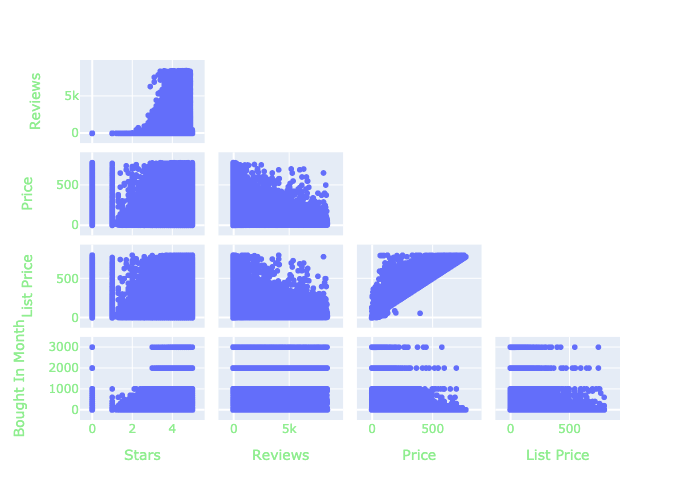

In [7]:
fig = px.scatter_matrix(df_az.select_dtypes("number"))
fig.update_traces(diagonal_visible=False, showupperhalf=False)
fig.show(renderer="png")

### Running and Results

In [27]:
lr_X = df_lr["Reviews"].to_numpy().reshape(-1, 1)

lr = LinearRegression()
lr.fit(lr_X, df_lr["Stars"])

reg_metrics = [metrics.mean_squared_error, metrics.mean_absolute_error, metrics.explained_variance_score, metrics.r2_score]
print(pd.DataFrame([{"Metric": m.__name__, "Value": m(df_lr["Stars"], lr.predict(lr_X))} for m in reg_metrics]).to_markdown(index=False))
print(lr.__dict__)

| Metric                   |      Value |
|:-------------------------|-----------:|
| mean_squared_error       | 1.819      |
| mean_absolute_error      | 0.849941   |
| explained_variance_score | 0.00510836 |
| r2_score                 | 0.00510836 |
{'fit_intercept': True, 'copy_X': True, 'n_jobs': None, 'positive': False, 'n_features_in_': 1, 'coef_': array([0.00016959]), 'rank_': 1, 'singular_': array([671798.84505162]), 'intercept_': 3.974664649695709}


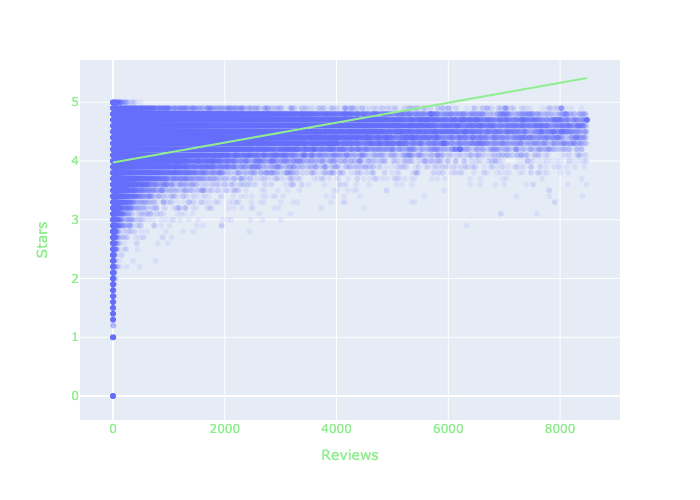

In [36]:
lr_X_sorted = df_lr["Reviews"].sort_values()
lr_y_pred = lr.predict(lr_X_sorted.to_numpy().reshape(-1, 1))

fig = px.scatter(df_lr, x="Reviews", y="Stars", opacity=0.1, trendline="ols", trendline_color_override="lightgreen")
# fig.add_trace(go.Scatter(x=lr_X_sorted, y=lr_y_pred, name="Regression Line"))
# fig.data = fig.data[::-1]
fig.show(renderer="png")

-----
## Neural Networks

### Model Definition

In [101]:
class BaseNNAz(nn.Module):
    def __init__(self, in_dim, out_dim=1, activation_fn = nn.Sigmoid):
      super(BaseNNAz, self).__init__()
      self.layers = nn.Sequential(
          nn.Linear(in_dim, round(in_dim * 1.3)),
          activation_fn(),
          nn.Linear(round(in_dim * 1.3), round(in_dim * 0.75)),
          activation_fn(),
          nn.Linear(round(in_dim * 0.75), round(in_dim * 0.25)),
          activation_fn(),
          nn.Linear(round(in_dim * 0.25), out_dim)
      )

    # x represents our data
    def forward(self, x):
        x = self.layers(x)
        return x

nn_bs = BaseNNAz(train_bs.x.shape[1])
nn_pd = BaseNNAz(train_pd.x.shape[1])

### Training

In [112]:
loss_fn = nn.MSELoss()
opt = torch.optim.Adam

def train(model, optimizer, train_dl, test_dl, epochs=50):
    train_loss = []
    val_loss = []

    for e in range(epochs):
        # Make sure gradient tracking is on
        model.train(True)
        
        running_loss = 0.
        running_vloss = 0.
        for inputs, target in iter(train_dl):
            # Zero your gradients for every batch!
            optimizer.zero_grad()
            # Make predictions for this batch
            outputs = model(inputs)
            # Compute the loss and its gradients
            loss = loss_fn(outputs, target)
            loss.backward()
            # Adjust learning weights
            optimizer.step()
            # Gather data
            running_loss += loss.item()

        train_loss.append(running_loss / len(train_dl))
        
        # Set the model to evaluation mode
        model.eval()
        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for vinputs, vtarget in iter(test_dl):
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vtarget)
                running_vloss += vloss
        val_loss.append(running_vloss / len(test_dl))

        print(f"Epoch {e} Loss: {train_loss[-1]}\t Validation Loss: {val_loss[-1]}")

In [111]:
train(nn_bs, opt(nn_bs.parameters()), train_bs_dl, test_bs_dl)

/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch 0 Loss: 0.004872706956220245	 Validation Loss: 0.004872297868132591


KeyboardInterrupt: 